## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process4.84375
[[ 0.74574069 -0.38061625 -0.54681084]
 [ 0.88900744 -0.05611495 -0.45444128]
 [ 0.84329039 -0.01482579 -0.53725368]
 ...
 [ 0.90817065 -0.12554912 -0.39932879]
 [ 0.8938326   0.05543122 -0.44496142]
 [ 0.85223471 -0.5018468   0.1478032 ]]


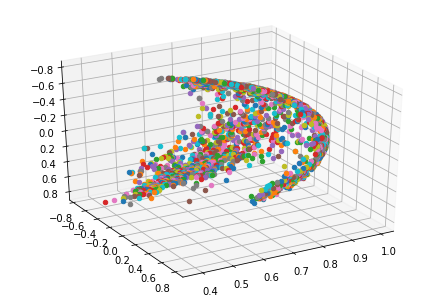

In [2]:
all_texts=[]
Y = []
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [17]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(confusion_matrix(Y, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [18]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [19]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#333333','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 120)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 8.106093087096651
Generation: 2 | Best fitness: 9.815138375980558
Generation: 3 | Best fitness: 9.92374578649411
Generation: 4 | Best fitness: 10.145441636942387
Generation: 5 | Best fitness: 9.789556348664549
Generation: 6 | Best fitness: 10.258837413767939
Generation: 7 | Best fitness: 13.010566386360166
Generation: 8 | Best fitness: 13.010566386360146
Generation: 9 | Best fitness: 8.358692628828651
Generation: 10 | Best fitness: 7.792319036293061
Generation: 11 | Best fitness: 9.788305542429443
Generation: 12 | Best fitness: 9.726728406311604
Generation: 13 | Best fitness: 7.409089042380561
Generation: 14 | Best fitness: 9.141505756989257
Generation: 15 | Best fitness: 8.220463655706318
Generation: 16 | Best fitness: 9.80571499318912
Generation: 17 | Best fitness: 9.925756597517085
Generation: 18 | Best fitness: 9.093174497071221
Generation: 19 | Best fitness: 11.38140745516376
Generation: 20 | Best fitness: 12.344554882568648
Generation: 21 | Best fitn

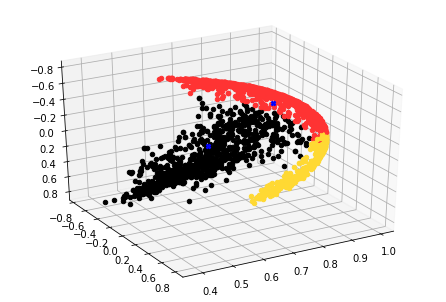

In [20]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 21.306307479348657
Generation: 2 | Best fitness: 20.116961984938243
Generation: 3 | Best fitness: 23.630209684752973
Generation: 4 | Best fitness: 24.495540019990823
Generation: 5 | Best fitness: 23.924263498483036
Generation: 6 | Best fitness: 23.059944666067334
Generation: 7 | Best fitness: 25.031751670936657
Generation: 8 | Best fitness: 24.64420754772132
Generation: 9 | Best fitness: 17.95427720862996
Generation: 10 | Best fitness: 24.416657876699617
Generation: 11 | Best fitness: 24.416657876699592
Generation: 12 | Best fitness: 21.67227748514094
Generation: 13 | Best fitness: 27.608286005014403
Generation: 14 | Best fitness: 22.528375570331956
Generation: 15 | Best fitness: 20.29646338488805
Generation: 16 | Best fitness: 19.491114737022013
Generation: 17 | Best fitness: 22.12874689429497
Generation: 18 | Best fitness: 22.128746894295077
Generation: 19 | Best fitness: 25.64704448554521
Generation: 20 | Best fitness: 25.096188813950402
Generation: 21 

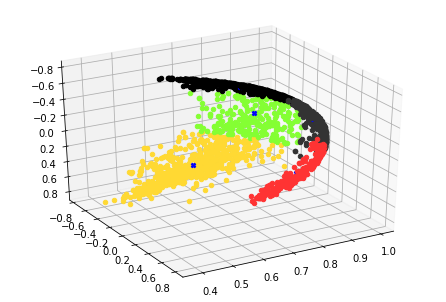

In [21]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 32.350745657559585
Generation: 2 | Best fitness: 32.54961997717164
Generation: 3 | Best fitness: 29.744089213206678
Generation: 4 | Best fitness: 26.358917790414147
Generation: 5 | Best fitness: 44.06267263704856


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 6 | Best fitness: 44.06267263704853


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 7 | Best fitness: 33.16221190873349
Generation: 8 | Best fitness: 37.90515015005823
Generation: 9 | Best fitness: 35.386577920373604
Generation: 10 | Best fitness: 31.243250937502832
Generation: 11 | Best fitness: 41.344915741828636
Generation: 12 | Best fitness: 39.74873908274173
Generation: 13 | Best fitness: 37.81102072438445
Generation: 14 | Best fitness: 38.58069771362798
Generation: 15 | Best fitness: 38.522909237271364
Generation: 16 | Best fitness: 40.47286567876029
Generation: 17 | Best fitness: 40.472865678760314


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 18 | Best fitness: 33.32649363641407
Generation: 19 | Best fitness: 30.02158259910381
Generation: 20 | Best fitness: 29.358910346005203
Generation: 21 | Best fitness: 36.85318356372717
Generation: 22 | Best fitness: 44.981303354283256
Generation: 23 | Best fitness: 42.0580733626122
Generation: 24 | Best fitness: 41.645567823508614
Generation: 25 | Best fitness: 36.084126563203014
Generation: 26 | Best fitness: 38.46721867779422
Generation: 27 | Best fitness: 44.39609486837633
Generation: 28 | Best fitness: 44.39609486837625
Generation: 29 | Best fitness: 24.39214059359654
Generation: 30 | Best fitness: 38.77206967262705
Generation: 31 | Best fitness: 47.716330101237865
Generation: 32 | Best fitness: 55.140837762770275
Generation: 33 | Best fitness: 55.140837762770296
Generation: 34 | Best fitness: 30.045826687609182
Generation: 35 | Best fitness: 40.771707596469405
Generation: 36 | Best fitness: 30.167290692215254
Generation: 37 | Best fitness: 37.64847728876881
Generation:

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 84 | Best fitness: 31.130839094003104
Generation: 85 | Best fitness: 40.77744173961646
Generation: 86 | Best fitness: 40.777441739616464
Generation: 87 | Best fitness: 37.913746286030644
Generation: 88 | Best fitness: 29.932265200553584
Generation: 89 | Best fitness: 34.85449261969426
Generation: 90 | Best fitness: 32.93909182490868
Generation: 91 | Best fitness: 35.370340513364965
Generation: 92 | Best fitness: 36.70876373813157
Generation: 93 | Best fitness: 36.70876373813147
Generation: 94 | Best fitness: 37.143706135398276
Generation: 95 | Best fitness: 23.60309710983254
Generation: 96 | Best fitness: 29.1295917683294
Generation: 97 | Best fitness: 27.059537298341752
Generation: 98 | Best fitness: 32.06515765315207
Generation: 99 | Best fitness: 30.542366094129623
Generation: 100 | Best fitness: 27.926722502736386
Time taken: 3913.96875
DB Index        :1.6702790074527194
Silhoutte Index :0.9107420603656655
248
177
195
746
163
371
325


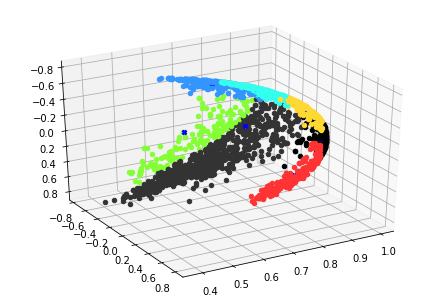

In [22]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 36.59588832047909
Generation: 2 | Best fitness: 38.88058473167542
Generation: 3 | Best fitness: 40.311508228462785
Generation: 4 | Best fitness: 43.25420527844627
Generation: 5 | Best fitness: 43.25420527844641


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 6 | Best fitness: 44.17654388169563
Generation: 7 | Best fitness: 42.585491029394205


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 8 | Best fitness: 38.048111054611944
Generation: 9 | Best fitness: 38.04811105461187
Generation: 10 | Best fitness: 35.37673643298225
Generation: 11 | Best fitness: 57.53962917386906
Generation: 12 | Best fitness: 57.5396291738688


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 13 | Best fitness: 39.57597456857207
Generation: 14 | Best fitness: 44.289271627042375
Generation: 15 | Best fitness: 42.77520850394427
Generation: 16 | Best fitness: 44.27780866075752


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 17 | Best fitness: 44.27780866075761
Generation: 18 | Best fitness: 37.71391156247606
Generation: 19 | Best fitness: 42.4337509620685
Generation: 20 | Best fitness: 38.05958262639865
Generation: 21 | Best fitness: 40.20111272745894
Generation: 22 | Best fitness: 40.20111272745908


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 23 | Best fitness: 45.972527165983706
Generation: 24 | Best fitness: 45.972527165983536
Generation: 25 | Best fitness: 37.65992645403263
Generation: 26 | Best fitness: 36.15270215372769
Generation: 27 | Best fitness: 36.270930066607875
Generation: 28 | Best fitness: 43.192376693182396
Generation: 29 | Best fitness: 43.19237669318237
Generation: 30 | Best fitness: 39.97710105717721


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 31 | Best fitness: 42.119641448060776
Generation: 32 | Best fitness: 36.800272512352066
Generation: 33 | Best fitness: 35.708717521139796
Generation: 34 | Best fitness: 38.89410104999172
Generation: 35 | Best fitness: 38.89410104999163
Generation: 36 | Best fitness: 41.19010448373139
Generation: 37 | Best fitness: 38.220566691564635
Generation: 38 | Best fitness: 35.082158388609884
Generation: 39 | Best fitness: 37.90294672370091
Generation: 40 | Best fitness: 37.167914855861916
Generation: 41 | Best fitness: 33.467101783725255
Generation: 42 | Best fitness: 42.45562832374225
Generation: 43 | Best fitness: 45.72956870691952
Generation: 44 | Best fitness: 39.957687827457626
Generation: 45 | Best fitness: 39.957687827457846
Generation: 46 | Best fitness: 40.10482317857022
Generation: 47 | Best fitness: 39.28725073712124
Generation: 48 | Best fitness: 38.080888500715616
Generation: 49 | Best fitness: 40.06954730842726
Generation: 50 | Best fitness: 38.84666195602371
Generation

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 71 | Best fitness: 34.32477112859292
Generation: 72 | Best fitness: 33.471568113115595
Generation: 73 | Best fitness: 33.47156811311554
Generation: 74 | Best fitness: 35.74285948517142
Generation: 75 | Best fitness: 36.8400395386141
Generation: 76 | Best fitness: 32.165024246166375
Generation: 77 | Best fitness: 34.09021303255558
Generation: 78 | Best fitness: 31.368825838471
Generation: 79 | Best fitness: 33.297253992942366
Generation: 80 | Best fitness: 35.22775899809519
Generation: 81 | Best fitness: 35.750334994260335
Generation: 82 | Best fitness: 32.97599765978338
Generation: 83 | Best fitness: 32.997454058399235
Generation: 84 | Best fitness: 32.45130815918661
Generation: 85 | Best fitness: 32.36972859275418
Generation: 86 | Best fitness: 34.39924406558738
Generation: 87 | Best fitness: 33.49202016190824


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 88 | Best fitness: 33.76820115610798
Generation: 89 | Best fitness: 35.98943700880417
Generation: 90 | Best fitness: 35.94059587389897
Generation: 91 | Best fitness: 34.42404724584935
Generation: 92 | Best fitness: 32.85907544154182
Generation: 93 | Best fitness: 31.88784087827593
Generation: 94 | Best fitness: 31.444385442956374
Generation: 95 | Best fitness: 29.958620953041258
Generation: 96 | Best fitness: 36.69264496304184
Generation: 97 | Best fitness: 31.958535316642415
Generation: 98 | Best fitness: 31.54097862158626
Generation: 99 | Best fitness: 35.06379756376708
Generation: 100 | Best fitness: 31.117457331522907
Time taken: 5130.203125
DB Index        :0.8955258626798684
Silhoutte Index :0.960071522427516
143
171
107
128
232
159
330
569
386


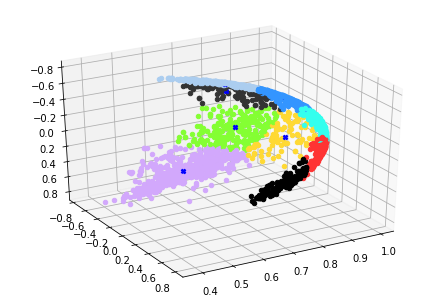

In [23]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)